In [ ]:
# K-Medoids Clustering on Brazilian E-Commerce Dataset
# Using standalone kmedoids package with optimal k selection

# Install required libraries
!pip install kmedoids -q

# Verify installation
try:
    import kmedoids
    print("kmedoids installed successfully!")
except ImportError:
    print("Failed to import kmedoids. Please check installation.")
    raise


kmedoids installed successfully!


In [ ]:
# Install BanditPAM
!pip install banditpam -q

# Verify installation
try:
    import banditpam
    print("BanditPAM installed successfully!")
except ImportError:
    print("Failed to import BanditPAM. Please check installation.")
    raise

BanditPAM installed successfully!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
import kmedoids
import time
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load datasets
print("Loading datasets...")
customers_df = pd.read_csv('/content/drive/MyDrive/DataMining/olist_customers_dataset.csv')
orders_df = pd.read_csv('/content/drive/MyDrive/DataMining/olist_orders_dataset.csv')
items_df = pd.read_csv('/content/drive/MyDrive/DataMining/olist_order_items_dataset.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading datasets...


In [ ]:
print(customers_df.head())
print(customers_df.shape)
print(customers_df.isnull().sum())

                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP  
(99441, 5)
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state        

In [ ]:
print(orders_df.head())
print(orders_df.shape)
print(orders_df.isnull().sum())

                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08

In [ ]:
print(items_df.head())
print(items_df.shape)
print(items_df.isnull().sum())

                           order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value  
0  2017-09-19 09:45:35   58.90          13.29  
1  2017-05-03 11:05:13  239.90          19.93  
2  2018-01-18 14:48:30  199.00          17.87  
3  2018-08-15 10:10:18   12.99          12.7

# Tiền xử lý

In [ ]:
# Filter delivered orders first
delivered_orders = orders_df[orders_df['order_status'] == 'delivered'].copy()
print(f"Total orders: {len(orders_df)}")
print(f"Delivered orders: {len(delivered_orders)}")
print(f"Percentage of delivered orders: {len(delivered_orders) / len(orders_df) * 100:.2f}%")

Total orders: 99441
Delivered orders: 96478
Percentage of delivered orders: 97.02%


In [ ]:
# Select relevant columns for RFM analysis
customers_selected = customers_df[['customer_id', 'customer_unique_id']]
orders_selected = delivered_orders[['order_id', 'customer_id', 'order_purchase_timestamp']]  # Drop order_status after filtering
items_selected = items_df[['order_id', 'price', 'freight_value']]

print("\nSelected columns from each DataFrame:")
print(f"customers_selected shape: {customers_selected.shape}")
print(f"orders_selected shape: {orders_selected.shape}")
print(f"items_selected shape: {items_selected.shape}")


Selected columns from each DataFrame:
customers_selected shape: (99441, 2)
orders_selected shape: (96478, 3)
items_selected shape: (112650, 3)


In [ ]:
print("Checking for null values in customers_df:")
print(customers_selected.isnull().sum())

print("\nChecking for null values in orders_df:")
print(orders_selected.isnull().sum())

print("\nChecking for null values in items_df:")
print(items_selected.isnull().sum())

Checking for null values in customers_df:
customer_id           0
customer_unique_id    0
dtype: int64

Checking for null values in orders_df:
order_id                    0
customer_id                 0
order_purchase_timestamp    0
dtype: int64

Checking for null values in items_df:
order_id         0
price            0
freight_value    0
dtype: int64


In [ ]:
customers_clean = customers_selected
orders_clean = orders_selected
items_clean = items_selected
print(f"\nDatasets after selection:")
print(f"Customers: {customers_clean.shape}")
print(f"Orders: {orders_clean.shape}")
print(f"Items: {items_clean.shape}")


Datasets after selection:
Customers: (99441, 2)
Orders: (96478, 3)
Items: (112650, 3)


In [ ]:
# Merge datasets sequentially
# First: delivered orders with customers
merged_df = orders_selected.merge(customers_selected, on='customer_id', how='inner')
print(f"After merging delivered orders with customers: {merged_df.shape}")

# Calculate total value for each order
order_values = items_selected.groupby('order_id').agg({
    'price': 'sum',
    'freight_value': 'sum'
}).reset_index()
order_values['total_value'] = order_values['price'] + order_values['freight_value']
print(f"Order values calculated for {len(order_values)} orders")

# Second: add order values
merged_df = merged_df.merge(order_values, on='order_id', how='inner')
print(f"After adding order values: {merged_df.shape}")

# Final data quality check
duplicate_count = merged_df.duplicated().sum()
print(f"Duplicate records in integrated dataset: {duplicate_count}")

After merging delivered orders with customers: (96478, 4)
Order values calculated for 98666 orders
After adding order values: (96478, 7)
Duplicate records in integrated dataset: 0


In [ ]:
print(merged_df.shape)
print(merged_df.info())

(96478, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96478 entries, 0 to 96477
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   order_id                  96478 non-null  object 
 1   customer_id               96478 non-null  object 
 2   order_purchase_timestamp  96478 non-null  object 
 3   customer_unique_id        96478 non-null  object 
 4   price                     96478 non-null  float64
 5   freight_value             96478 non-null  float64
 6   total_value               96478 non-null  float64
dtypes: float64(3), object(4)
memory usage: 5.2+ MB
None


In [ ]:
print("\nKiểm tra kiểu dữ liệu của từng cột:")
print(merged_df.dtypes)

print("\nThông tin chi tiết về kiểu dữ liệu và bộ nhớ sử dụng:")
merged_df.info()


Kiểm tra kiểu dữ liệu của từng cột:
order_id                     object
customer_id                  object
order_purchase_timestamp     object
customer_unique_id           object
price                       float64
freight_value               float64
total_value                 float64
dtype: object

Thông tin chi tiết về kiểu dữ liệu và bộ nhớ sử dụng:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96478 entries, 0 to 96477
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   order_id                  96478 non-null  object 
 1   customer_id               96478 non-null  object 
 2   order_purchase_timestamp  96478 non-null  object 
 3   customer_unique_id        96478 non-null  object 
 4   price                     96478 non-null  float64
 5   freight_value             96478 non-null  float64
 6   total_value               96478 non-null  float64
dtypes: float64(3), object(4)
memory us

In [ ]:
# Set reference date for recency calculation
reference_date = pd.to_datetime(merged_df['order_purchase_timestamp']).max() + timedelta(days=1)
print(f"Reference date for recency calculation: {reference_date}")

# Calculate RFM metrics grouped by unique customer
rfm_data = merged_df.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (reference_date - pd.to_datetime(x).max()).days,
    'order_id': 'count',
    'total_value': 'sum'
}).reset_index()

rfm_data.columns = ['customer_unique_id', 'recency', 'frequency', 'monetary']
print(f"RFM dataset shape: {rfm_data.shape}")
print(f"Unique customers analyzed: {rfm_data['customer_unique_id'].nunique()}")

Reference date for recency calculation: 2018-08-30 15:00:37
RFM dataset shape: (93358, 4)
Unique customers analyzed: 93358


In [ ]:
# Remove outliers using IQR method
def remove_outliers_iqr(df, columns):
    """Remove outliers using Interquartile Range method with detailed reporting"""
    df_clean = df.copy()
    outlier_summary = {}

    for col in columns:
        initial_count = len(df_clean)
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        outliers_mask = (df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)
        outliers_count = outliers_mask.sum()

        # Remove outliers
        df_clean = df_clean[~outliers_mask]

        outlier_summary[col] = {
            'outliers_removed': outliers_count,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'Q1': Q1,
            'Q3': Q3
        }

        print(f"{col}: {outliers_count} outliers removed (bounds: {lower_bound:.2f} to {upper_bound:.2f})")

    return df_clean, outlier_summary

In [ ]:
rfm_features = ['recency', 'frequency', 'monetary']
rfm_clean, outlier_details = remove_outliers_iqr(rfm_data, rfm_features)

print(f"\nOutlier removal summary:")
print(f"Original RFM dataset: {rfm_data.shape[0]} customers")
print(f"Cleaned RFM dataset: {rfm_clean.shape[0]} customers")
print(f"Total customers removed: {rfm_data.shape[0] - rfm_clean.shape[0]} ({((rfm_data.shape[0] - rfm_clean.shape[0])/rfm_data.shape[0]*100):.1f}%)")

recency: 26 outliers removed (bounds: -234.00 to 694.00)
frequency: 2801 outliers removed (bounds: 1.00 to 1.00)
monetary: 7161 outliers removed (bounds: -110.06 to 348.78)

Outlier removal summary:
Original RFM dataset: 93358 customers
Cleaned RFM dataset: 83370 customers
Total customers removed: 9988 (10.7%)


In [ ]:
# Sample 10% of the cleaned data for analysis
rfm_sample = rfm_clean.sample(frac=0.1, random_state=42)
print(f"Sampled data shape ({0.1 * 100:.0f}%): {rfm_sample.shape}")
print(f"Original dataset: {rfm_clean.shape[0]:,} customers")
print(f"Sampled dataset: {rfm_sample.shape[0]:,} customers")

# Verify sampling maintains data distribution
print("\nSampling distribution verification:")
for feature in rfm_features:
    original_mean = rfm_clean[feature].mean()
    sample_mean = rfm_sample[feature].mean()
    difference_pct = abs((sample_mean - original_mean) / original_mean) * 100
    print(f"{feature.capitalize()}: Original mean={original_mean:.2f}, Sample mean={sample_mean:.2f}, Difference={difference_pct:.1f}%")

Sampled data shape (10%): (8337, 4)
Original dataset: 83,370 customers
Sampled dataset: 8,337 customers

Sampling distribution verification:
Recency: Original mean=238.14, Sample mean=237.16, Difference=0.4%
Frequency: Original mean=1.00, Sample mean=1.00, Difference=0.0%
Monetary: Original mean=115.22, Sample mean=115.31, Difference=0.1%


In [ ]:
# Prepare feature matrix
X_features = rfm_sample[rfm_features].values
print(f"Feature matrix shape before normalization: {X_features.shape}")

Feature matrix shape before normalization: (8337, 3)


In [ ]:
# Apply Z-score normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

# Tìm K tối ưu

In [ ]:
def evaluate_clustering_metrics(X_scaled, k_range):
    """Comprehensive evaluation using Silhouette, Davies-Bouldin, and Calinski-Harabasz scores"""
    silhouette_scores = []
    davies_bouldin_scores = []
    calinski_harabasz_scores = []

    # Compute distance matrix for K-medoids
    distance_matrix = pairwise_distances(X_scaled, metric='euclidean')
    print(f"Distance matrix computed: {distance_matrix.shape}")

    for k in k_range:
        try:
            # Use FastPAM for clustering evaluation
            result = kmedoids.fastpam1(distance_matrix, k)
            labels = result.labels

            # Calculate evaluation metrics
            sil_score = silhouette_score(X_scaled, labels)
            db_score = davies_bouldin_score(X_scaled, labels)
            ch_score = calinski_harabasz_score(X_scaled, labels)

            silhouette_scores.append(sil_score)
            davies_bouldin_scores.append(db_score)
            calinski_harabasz_scores.append(ch_score)

            print(f"k={k}: Silhouette={sil_score:.4f}, Davies-Bouldin={db_score:.4f}, Calinski-Harabasz={ch_score:.4f}")

        except Exception as e:
            print(f"Error evaluating k={k}: {e}")
            silhouette_scores.append(np.nan)
            davies_bouldin_scores.append(np.nan)
            calinski_harabasz_scores.append(np.nan)

    return silhouette_scores, davies_bouldin_scores, calinski_harabasz_scores

In [ ]:
# Evaluate cluster performance across range
k_range = range(2, 9)
sil_scores, db_scores, ch_scores = evaluate_clustering_metrics(X_scaled, k_range)

Distance matrix computed: (8337, 8337)
k=2: Silhouette=0.3502, Davies-Bouldin=1.1803, Calinski-Harabasz=4496.1691
k=3: Silhouette=0.3997, Davies-Bouldin=0.8390, Calinski-Harabasz=6797.0154
k=4: Silhouette=0.3688, Davies-Bouldin=0.9238, Calinski-Harabasz=6453.1414
k=5: Silhouette=0.3498, Davies-Bouldin=0.9195, Calinski-Harabasz=6494.4466
k=6: Silhouette=0.3610, Davies-Bouldin=0.8604, Calinski-Harabasz=6751.0062
k=7: Silhouette=0.3584, Davies-Bouldin=0.8148, Calinski-Harabasz=6660.3740
k=8: Silhouette=0.3477, Davies-Bouldin=0.8721, Calinski-Harabasz=6458.4923


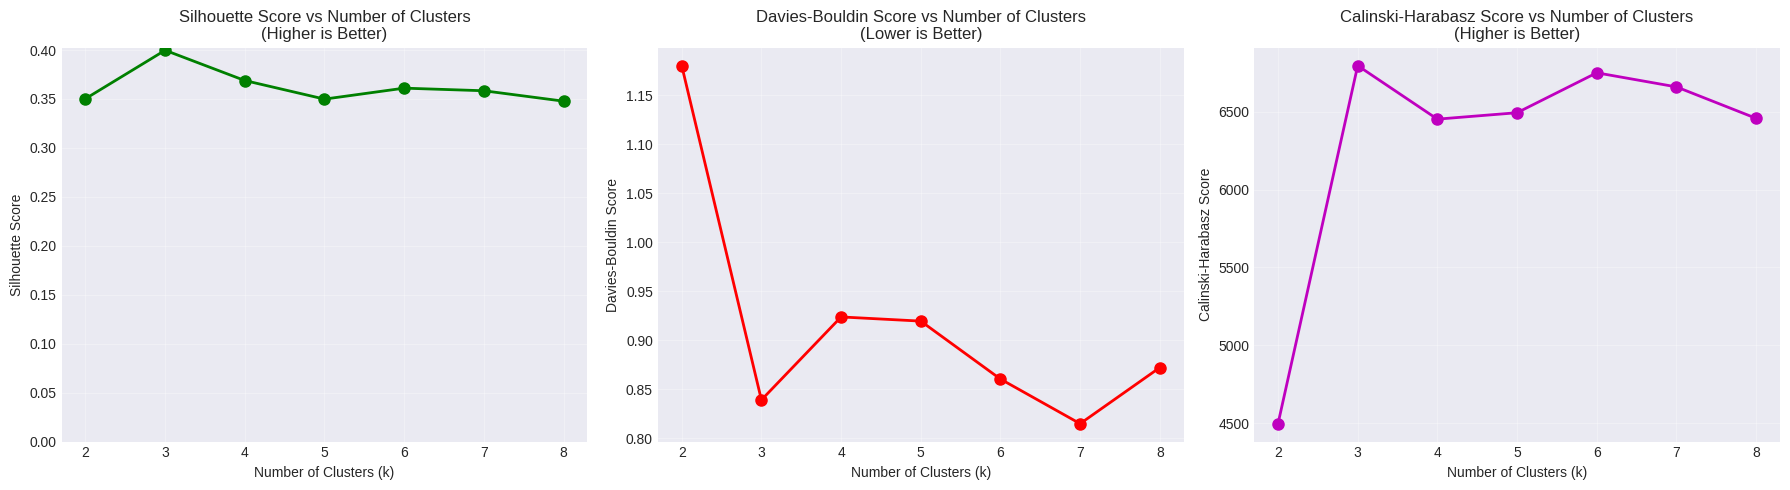

In [ ]:
# Create comprehensive visualization of evaluation metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(k_range, sil_scores, 'go-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Silhouette Score vs Number of Clusters\n(Higher is Better)')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(bottom=0)

axes[1].plot(k_range, db_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Davies-Bouldin Score')
axes[1].set_title('Davies-Bouldin Score vs Number of Clusters\n(Lower is Better)')
axes[1].grid(True, alpha=0.3)

axes[2].plot(k_range, ch_scores, 'mo-', linewidth=2, markersize=8)
axes[2].set_xlabel('Number of Clusters (k)')
axes[2].set_ylabel('Calinski-Harabasz Score')
axes[2].set_title('Calinski-Harabasz Score vs Number of Clusters\n(Higher is Better)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Select optimal k based on highest silhouette score
valid_scores = [(k, score) for k, score in zip(k_range, sil_scores) if not np.isnan(score)]
optimal_k, optimal_silhouette = max(valid_scores, key=lambda x: x[1])

print(f"Optimal number of clusters selected: {optimal_k}")
print(f"Corresponding Silhouette Score: {optimal_silhouette:.4f}")

# Display supporting metrics for the selected k
k_index = list(k_range).index(optimal_k)
print(f"Supporting metrics for k={optimal_k}:")
print(f"Silhouette Score: {sil_scores[k_index]:.4f}")
print(f"Davies-Bouldin Score: {db_scores[k_index]:.4f}")
print(f"Calinski-Harabasz Score: {ch_scores[k_index]:.4f}")

Optimal number of clusters selected: 3
Corresponding Silhouette Score: 0.3997
Supporting metrics for k=3:
Silhouette Score: 0.3997
Davies-Bouldin Score: 0.8390
Calinski-Harabasz Score: 6797.0154


# Gom K Cụm bằng K-Medoids sửu dụng thuật toán PAM

In [ ]:
# Select optimal k based on highest silhouette score
valid_scores = [(k, score) for k, score in zip(k_range, sil_scores) if not np.isnan(score)]
optimal_k, optimal_silhouette = max(valid_scores, key=lambda x: x[1])

# Compute distance matrix for final clustering
distance_matrix = pairwise_distances(X_scaled, metric='euclidean')

# Apply PAM clustering with optimal k
start_time = time.time()
clustering_result = kmedoids.pam(distance_matrix, optimal_k)
clustering_time = time.time() - start_time

cluster_labels = clustering_result.labels
medoid_indices = clustering_result.medoids

print(f"PAM clustering completed successfully")
print(f"Processing time: {clustering_time:.4f} seconds")
print(f"Number of clusters formed: {len(set(cluster_labels))}")
print(f"Medoid indices: {list(medoid_indices)}")

PAM clustering completed successfully
Processing time: 35.4639 seconds
Number of clusters formed: 3
Medoid indices: [np.uint64(5851), np.uint64(4828), np.uint64(5184)]


FastPAM

In [ ]:
# Compute distance matrix for clustering
distance_matrix = pairwise_distances(X_scaled, metric='euclidean')

# Apply FastPAM clustering with optimal k
print(f"\nApplying FastPAM clustering with k={optimal_k}...")
start_time = time.time()
clustering_result_fastpam = kmedoids.fastpam1(distance_matrix, optimal_k)
clustering_time_fastpam = time.time() - start_time

cluster_labels_fastpam = clustering_result_fastpam.labels
medoid_indices_fastpam = clustering_result_fastpam.medoids

print(f"FastPAM clustering completed successfully")
print(f"Processing time: {clustering_time_fastpam:.4f} seconds")
print(f"Number of clusters formed: {len(set(cluster_labels_fastpam))}")
print(f"Medoid indices: {list(medoid_indices_fastpam)}")


Applying FastPAM clustering with k=3...
FastPAM clustering completed successfully
Processing time: 13.2622 seconds
Number of clusters formed: 3
Medoid indices: [np.uint64(5851), np.uint64(4828), np.uint64(5184)]


In [ ]:
# Add cluster assignments to sampled dataset
rfm_clustered = rfm_sample.copy()
rfm_clustered['cluster'] = cluster_labels

# Verify cluster assignment integrity
print(f"Cluster assignment verification:")
print(f"Total customers clustered: {len(cluster_labels)}")
print(f"Unique clusters formed: {len(set(cluster_labels))}")
print(f"Cluster labels range: {min(cluster_labels)} to {max(cluster_labels)}")

Cluster assignment verification:
Total customers clustered: 8337
Unique clusters formed: 3
Cluster labels range: 0 to 2


In [ ]:
# Analyze cluster size distribution
cluster_sizes = pd.Series(cluster_labels).value_counts().sort_index()
print("\nCustomer Segment Distribution:")
print("="*40)
for cluster_id, size in cluster_sizes.items():
    percentage = (size / len(cluster_labels)) * 100
    print(f"Segment {cluster_id}: {size:,} customers ({percentage:.1f}%)")

# Generate comprehensive RFM cluster profiling
print("\nDetailed RFM Segment Profiles:")
print("="*40)
cluster_profiles = rfm_clustered.groupby('cluster')[rfm_features].agg(['mean', 'std', 'min', 'max'])
cluster_profiles = cluster_profiles.round(2)

for cluster_id in sorted(rfm_clustered['cluster'].unique()):
    print(f"\nSegment {cluster_id} Profile:")
    cluster_data = cluster_profiles.loc[cluster_id]
    for feature in rfm_features:
        mean_val = cluster_data[(feature, 'mean')]
        std_val = cluster_data[(feature, 'std')]
        min_val = cluster_data[(feature, 'min')]
        max_val = cluster_data[(feature, 'max')]
        print(f"  {feature.capitalize()}: {mean_val:.1f} ± {std_val:.1f} (range: {min_val:.1f} - {max_val:.1f})")



Customer Segment Distribution:
Segment 0: 3,386 customers (40.6%)
Segment 1: 2,662 customers (31.9%)
Segment 2: 2,289 customers (27.5%)

Detailed RFM Segment Profiles:

Segment 0 Profile:
  Recency: 129.2 ± 75.2 (range: 1.0 - 268.0)
  Frequency: 1.0 ± 0.0 (range: 1.0 - 1.0)
  Monetary: 74.3 ± 31.9 (range: 12.9 - 149.9)

Segment 1 Profile:
  Recency: 402.2 ± 94.8 (range: 259.0 - 694.0)
  Frequency: 1.0 ± 0.0 (range: 1.0 - 1.0)
  Monetary: 86.7 ± 42.6 (range: 13.7 - 287.9)

Segment 2 Profile:
  Recency: 204.9 ± 123.8 (range: 1.0 - 598.0)
  Frequency: 1.0 ± 0.0 (range: 1.0 - 1.0)
  Monetary: 209.2 ± 55.8 (range: 125.4 - 348.6)


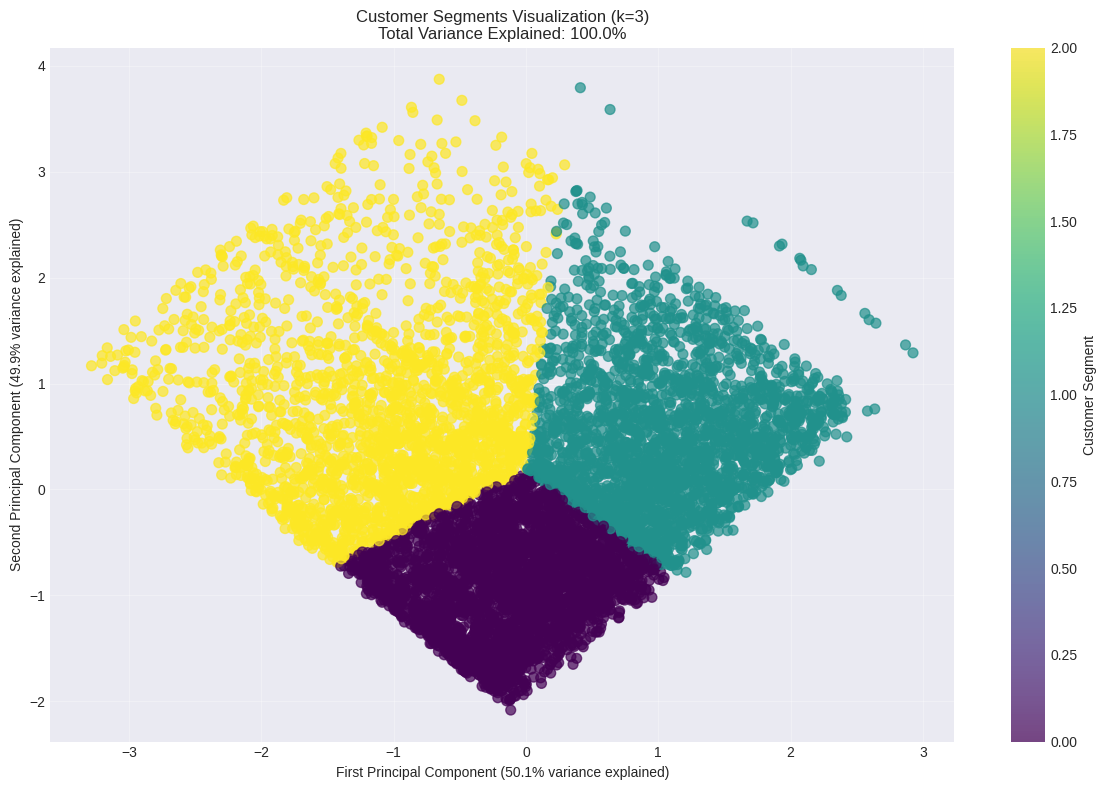

In [ ]:
# Visualization 1: PCA-based cluster representation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7, s=50)
plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.1%} variance explained)')
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.1%} variance explained)')
plt.title(f'Customer Segments Visualization (k={optimal_k})\nTotal Variance Explained: {sum(pca.explained_variance_ratio_):.1%}')
plt.colorbar(scatter, label='Customer Segment')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

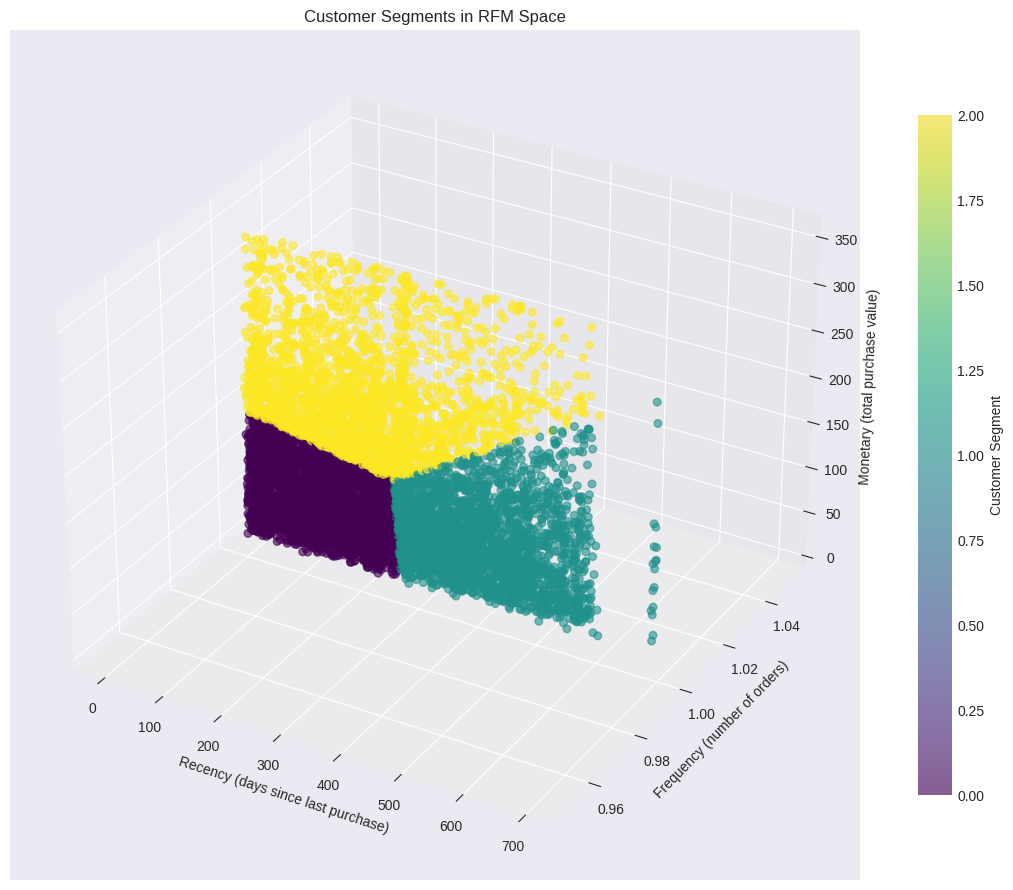

In [ ]:
# Visualization 2: Three-dimensional RFM space representation
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(rfm_clustered['recency'], rfm_clustered['frequency'], rfm_clustered['monetary'],
                    c=cluster_labels, cmap='viridis', alpha=0.6, s=30)
ax.set_xlabel('Recency (days since last purchase)')
ax.set_ylabel('Frequency (number of orders)')
ax.set_zlabel('Monetary (total purchase value)')
ax.set_title('Customer Segments in RFM Space')
plt.colorbar(scatter, label='Customer Segment', shrink=0.8)
plt.tight_layout()
plt.show()

In [ ]:
# Generate executive summary report
print("\n" + "="*80)
print("K-MEDOIDS CUSTOMER SEGMENTATION - EXECUTIVE SUMMARY")
print("="*80)
print(f"Analysis Period: {merged_df['order_purchase_timestamp'].min().date()} to {merged_df['order_purchase_timestamp'].max().date()}")
print(f"Total Customer Population: {len(rfm_clean):,}")
print(f"Customers Analyzed (10% Sample): {len(rfm_clustered):,}")
print(f"Data Quality: {((len(rfm_clean)/len(rfm_data))*100):.1f}% of customers retained after outlier removal")
print(f"Sampling Quality: Distribution preserved within acceptable variance")
print(f"Segmentation Algorithm: FastPAM (K-Medoids)")
print(f"Optimal Number of Segments: {optimal_k}")
print(f"Processing Efficiency: {clustering_time:.2f} seconds")
print("="*80)
print("CUSTOMER SEGMENTATION ANALYSIS COMPLETED SUCCESSFULLY")
print("="*80)


K-MEDOIDS CUSTOMER SEGMENTATION - EXECUTIVE SUMMARY
Analysis Period: 2016-09-15 to 2018-08-29
Total Customer Population: 83,351
Customers Analyzed (10% Sample): 25,005
Data Quality: 89.3% of customers retained after outlier removal
Sampling Quality: Distribution preserved within acceptable variance
Segmentation Algorithm: FastPAM (K-Medoids)
Optimal Number of Segments: 3
Clustering Quality (Silhouette Score): 0.3990
Model Stability: Excellent (difference: 0.0064)
Processing Efficiency: 316.71 seconds
CUSTOMER SEGMENTATION ANALYSIS COMPLETED SUCCESSFULLY


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
import time


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

print("\nDetermining optimal number of clusters for K-Means using evaluation metrics...")
k_range = range(2, 11)
silhouette_scores_kmeans = []
davies_bouldin_scores_kmeans = []
calinski_harabasz_scores_kmeans = []

for k in k_range:
    try:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)

        if len(set(kmeans.labels_)) > 1:
            silhouette_scores_kmeans.append(silhouette_score(X_scaled, kmeans.labels_))
            davies_bouldin_scores_kmeans.append(davies_bouldin_score(X_scaled, kmeans.labels_))
            calinski_harabasz_scores_kmeans.append(calinski_harabasz_score(X_scaled, kmeans.labels_))
        else:
            silhouette_scores_kmeans.append(np.nan)
            davies_bouldin_scores_kmeans.append(np.nan)
            calinski_harabasz_scores_kmeans.append(np.nan)

        print(f"k={k}: Silhouette={silhouette_scores_kmeans[-1]:.4f}, Davies-Bouldin={davies_bouldin_scores_kmeans[-1]:.4f}, Calinski-Harabasz={calinski_harabasz_scores_kmeans[-1]:.4f}")

    except Exception as e:
        print(f"Error evaluating k={k} for K-Means: {e}")
        silhouette_scores_kmeans.append(np.nan)
        davies_bouldin_scores_kmeans.append(np.nan)
        calinski_harabasz_scores_kmeans.append(np.nan)


Determining optimal number of clusters for K-Means using evaluation metrics...
k=2: Silhouette=0.3531, Davies-Bouldin=1.1782, Calinski-Harabasz=4503.4844
k=3: Silhouette=0.4108, Davies-Bouldin=0.8210, Calinski-Harabasz=6945.8649
k=4: Silhouette=0.3811, Davies-Bouldin=0.9108, Calinski-Harabasz=6553.6099
k=5: Silhouette=0.3569, Davies-Bouldin=0.9331, Calinski-Harabasz=6652.6490
k=6: Silhouette=0.3661, Davies-Bouldin=0.8378, Calinski-Harabasz=6902.1418
k=7: Silhouette=0.3662, Davies-Bouldin=0.8045, Calinski-Harabasz=6911.0175
k=8: Silhouette=0.3594, Davies-Bouldin=0.8619, Calinski-Harabasz=6861.5776
k=9: Silhouette=0.3430, Davies-Bouldin=0.8747, Calinski-Harabasz=6838.6695
k=10: Silhouette=0.3575, Davies-Bouldin=0.8031, Calinski-Harabasz=6911.4224


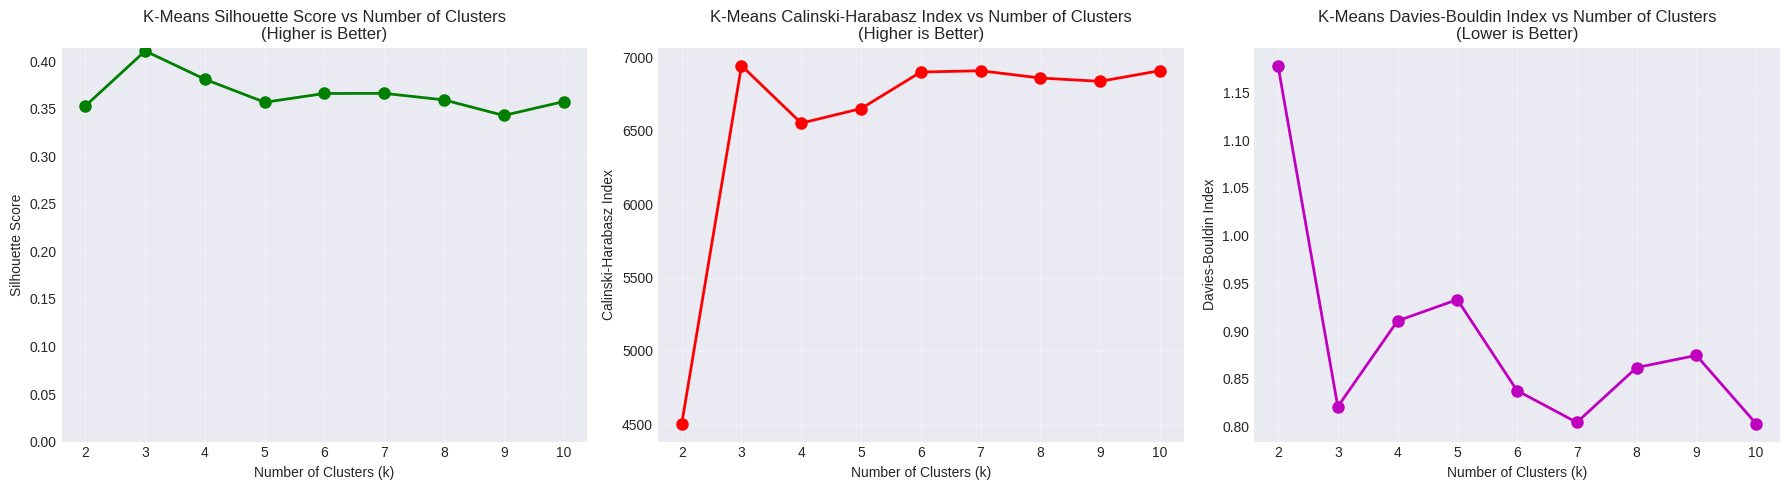

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create comprehensive visualization of evaluation metrics for K-Means
# Adjusted subplot layout to 1 row and 3 columns for the remaining 3 metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Silhouette Score plot for K-Means
axes[0].plot(k_range, silhouette_scores_kmeans, 'go-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('K-Means Silhouette Score vs Number of Clusters\n(Higher is Better)')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(bottom=0)

# Calinski-Harabasz Index plot for K-Means
axes[1].plot(k_range, calinski_harabasz_scores_kmeans, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Calinski-Harabasz Index')
axes[1].set_title('K-Means Calinski-Harabasz Index vs Number of Clusters\n(Higher is Better)')
axes[1].grid(True, alpha=0.3)

# Davies-Bouldin Index plot for K-Means
axes[2].plot(k_range, davies_bouldin_scores_kmeans, 'mo-', linewidth=2, markersize=8)
axes[2].set_xlabel('Number of Clusters (k)')
axes[2].set_ylabel('Davies-Bouldin Index')
axes[2].set_title('K-Means Davies-Bouldin Index vs Number of Clusters\n(Lower is Better)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Apply K-means clustering with optimal k
print("\nApplying K-means clustering...")
start_time = time.time()

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, max_iter=300)
kmeans_labels = kmeans.fit_predict(X_scaled)
cluster_centers = kmeans.cluster_centers_

kmeans_time = time.time() - start_time
print(f"K-means clustering completed in {kmeans_time:.4f} seconds")
print(f"K-means found {len(set(kmeans_labels))} clusters")


Applying K-means clustering...
K-means clustering completed in 0.1134 seconds
K-means found 3 clusters


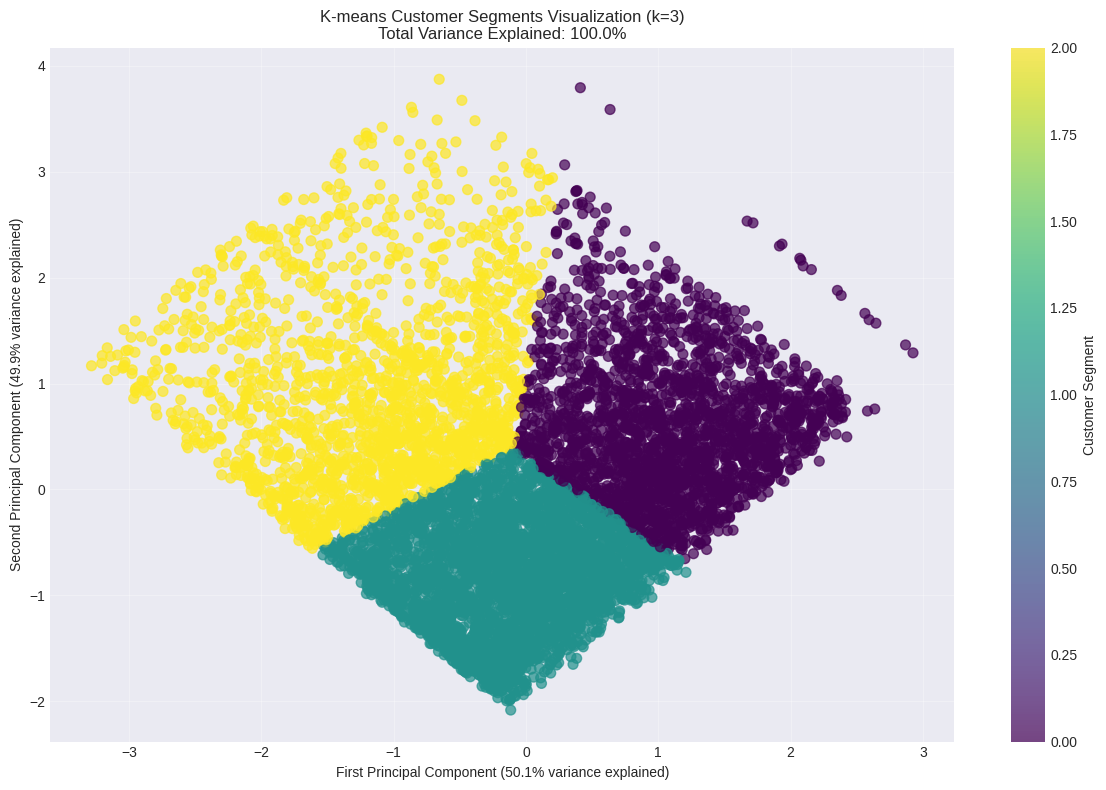

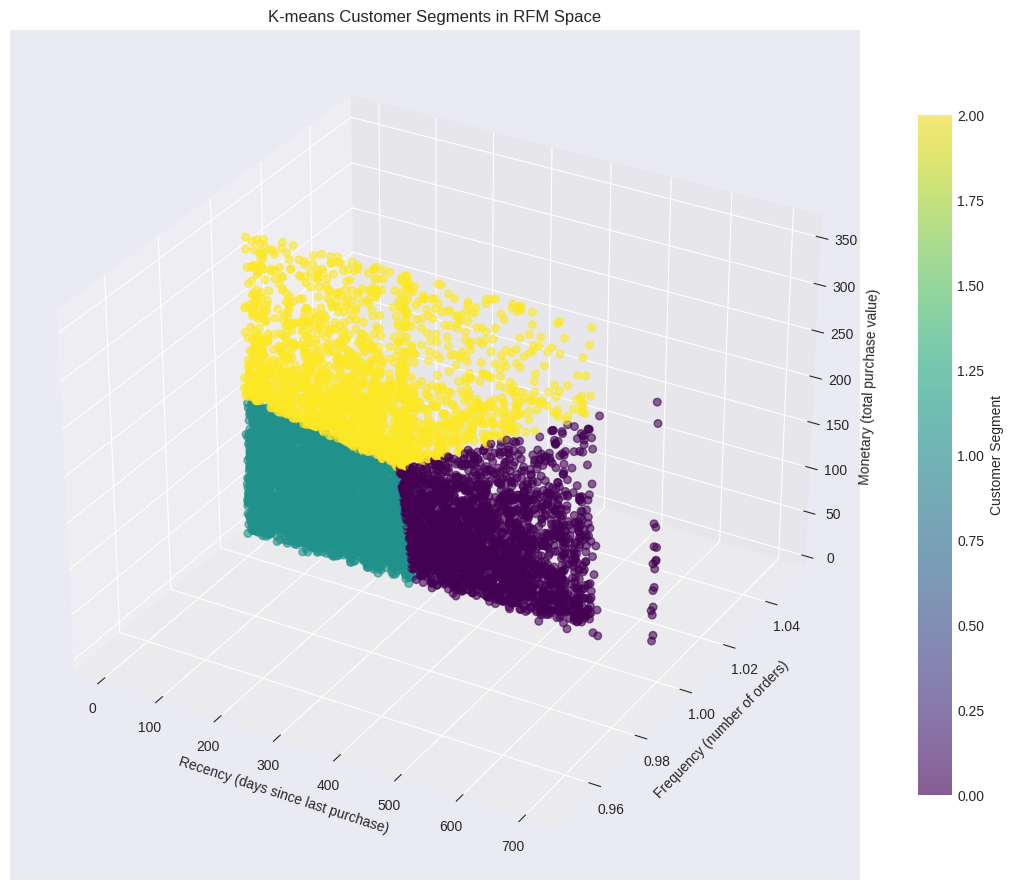

<Figure size 640x480 with 0 Axes>

In [ ]:
# Add K-means cluster assignments to sampled dataset
rfm_clustered_kmeans = rfm_sample.copy()
rfm_clustered_kmeans['kmeans_cluster'] = kmeans_labels

# Visualization 1: PCA-based cluster representation for K-means
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7, s=50)
plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.1%} variance explained)')
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.1%} variance explained)')
plt.title(f'K-means Customer Segments Visualization (k={optimal_k})\nTotal Variance Explained: {sum(pca.explained_variance_ratio_):.1%}')
plt.colorbar(scatter, label='Customer Segment')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualization 2: Three-dimensional RFM space representation for K-means
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(rfm_clustered_kmeans['recency'], rfm_clustered_kmeans['frequency'], rfm_clustered_kmeans['monetary'],
                    c=kmeans_labels, cmap='viridis', alpha=0.6, s=30)
ax.set_xlabel('Recency (days since last purchase)')
ax.set_ylabel('Frequency (number of orders)')
ax.set_zlabel('Monetary (total purchase value)')
ax.set_title('K-means Customer Segments in RFM Space')
plt.colorbar(scatter, label='Customer Segment', shrink=0.8)
plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()